In [437]:
#importing libraries

import random as rd
import hashlib
import phe
import rsa
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

In [438]:
#declaring of varibles
numberOfExperts = 0
numberOfCandidates = 0
keySize = 0
#collection of homomophic public and private keys
dictionaryOfExpertPublicKeys = {}
dictionaryOfExpertPrivateKeys = {}

dictionaryOfCandidatesPublicKeys = {}
dictionaryOfCandidatesPrivateKeys = {}

#Variables for third and 4th framework@
dictionaryOfRandomNumberPerExpert = {}
dictionaryOftheSumOfRandomNumbermappedToEveryCandidate = {}
dictionaryOfRandomNumberGatheredFromOtherExperts = {}
dictionaryOfRandomNumberMappedToEveryCandidate = {}
publicKeyEmployer,privateKeyEmployer = 0,0

#Collection of rsa public and private keys for digital signature
dictOfrsaPubKey = {}
dictOfrsaPriKey = {}
marksToCandidates = []

In [439]:
def initVariables(E,C, key):
    global numberOfExperts, numberOfCandidates, keySize
    numberOfExperts, numberOfCandidates ,keySize= E, C , key

In [440]:
#this part of the code create the public and private homomorphic key pairs
#this part of the code create the public and private homomorphic key pairs
def generateHomomorphickeyPairs():
    global publicKeyEmployer,privateKeyEmployer
    publicKeyEmployer,privateKeyEmployer = phe.generate_paillier_keypair(n_length=keySize)
    for i in range(numberOfExperts):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfExpertPublicKeys[i] = x
        dictionaryOfExpertPrivateKeys[i] = y
        
    for i in range(numberOfCandidates):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfCandidatesPublicKeys[i]= x
        dictionaryOfCandidatesPrivateKeys[i] = y 



In [441]:
#code to generate rsa public and private keys
def generateRSAKeys():
    global dictOfrsaPubKey, dicOfrsaPriKey
    for i in range(numberOfExperts):
        (pubkey, privkey) = rsa.newkeys(512)
        dictOfrsaPubKey[i],dictOfrsaPriKey[i] = pubkey, privkey 

In [442]:
# function to create digital signature
def createDigitalSignature(message,i):
    privkey = dictOfrsaPriKey[i]
    temp = str(message).encode()
    signature = rsa.sign(temp, privkey, 'SHA-1')
    return signature

In [443]:
def generateRandomNumberForEveryExpert():
    # global dictionaryOfRandomNumberPerExpert
    generatedRandomNumbers = [rd.randint(0,100) for x in range(numberOfExperts)]
    # print(generatedRandomNumbers)
    return generatedRandomNumbers
    # print(dictionaryOfSumGeneratedPerRandomNumber)

In [444]:
def forwardTheRespectiveRandomNumbers(idR,generatedRandomNumbers):
    encryptedRandomNumber = dictionaryOfExpertPublicKeys[idR].raw_encrypt(generatedRandomNumbers[idR])
    message = encryptedRandomNumber
    return message
# ,createDigitalSignature(encryptedRandomNumber,idS)

In [445]:
def performSMPCBetweenExperts():
    #this part of the code simulates the part where expert follow the smpc process
    #the random number assgned by all the experts has been mapped for every candidate
    
    for i in range(numberOfCandidates):
        matrixOfForwardedMessages = [[0 for i in range(numberOfExperts)] for j in range(numberOfExperts)]
        sumList = []
        for j in range(numberOfExperts):
            generatedRandomNumbers = generateRandomNumberForEveryExpert()
            sumOfTheRandomNumbers = sum(generatedRandomNumbers) 
            sumList.append(sumOfTheRandomNumbers)

            for k in range(numberOfExperts):
                if(j != k):
                    message = forwardTheRespectiveRandomNumbers(k,generatedRandomNumbers)
                    matrixOfForwardedMessages[j][k] = message
                else:
                    matrixOfForwardedMessages[j][k] = generatedRandomNumbers[j]
        dictionaryOfRandomNumberMappedToEveryCandidate[i] = matrixOfForwardedMessages
        dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i] = sumList
    # print(dictionaryOfRandomNumberMappedToEveryCandidate)
    # print(dictionaryOftheSumOfRandomNumbermappedToEveryCandidate)
    # print(dictionaryOfSumGeneratedPerRandomNumber)
    

    

In [446]:
def generateHiddenScoreFrameWork4():
    global marksToCandidates
    marksToCandidates = [[0 for i in range(numberOfCandidates)] for j in range(numberOfExperts)]
    for i in range(numberOfCandidates):
        for j in range(numberOfExperts):
            mark = rd.randint(0,100)
            hiddenScore = mark + dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i][j]
            sum  = 0
            for k in range(numberOfExperts):
                if(j != k):
                    encryptedRandomNumber = dictionaryOfRandomNumberMappedToEveryCandidate[i][k][j]
                    # print(encryptedRandomNumber)
                    sum  = sum + dictionaryOfExpertPrivateKeys[j].raw_decrypt(encryptedRandomNumber)
                else: 
                    sum = sum + dictionaryOfRandomNumberMappedToEveryCandidate[i][j][j]
            hiddenScore  = hiddenScore -sum
            # print(hiddenScore)
            marksToCandidates[j][i] = publicKeyEmployer.raw_encrypt(hiddenScore)

In [447]:
def candidateManagerFrameWork4BestCandidate():
    array = []
    for i in range(numberOfCandidates):
        sum = 1
        for j in range(numberOfExperts):
            cummulativeScore = marksToCandidates[j][i]
            sum  = sum * cummulativeScore
        array.append(sum)
    return array


In [448]:
def employerFindsTheBestCandidate(array):
    marksOfCandidates = [privateKeyEmployer.raw_decrypt(x) for x in array]
    # print(marksOfCandidates)
    # print(marksOfCandidates.index(max(marksOfCandidates)))


In [449]:
def expertFunctionToGiveMarks():
    performSMPCBetweenExperts()
    generateHiddenScoreFrameWork4()
    


In [450]:
def plotGraph(a,b):
    plt.plot(a,b,marker = "*")
    plt.xlabel("numberOfcandidates")
    plt.ylabel("time Consumed")
    plt.show()

In [451]:
def runSimulation(experts,candidates,flag,keySize):
    experts = experts
    timeList = []
    candidates = candidates

    if flag == "candidates":
        for i in range(len(candidates)):
            start = timer()
            initVariables(experts,candidates[i],keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            expertFunctionToGiveMarks()
            array = candidateManagerFrameWork4BestCandidate()
            employerFindsTheBestCandidate(array)
            end = timer()
            timeList.append(end - start)
    else: 
        for i in range(len(experts)):
            start = timer()
            initVariables(experts[i],candidates,keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            expertFunctionToGiveMarks()
            array = candidateManagerFrameWork4BestCandidate()
            employerFindsTheBestCandidate(array)
            end = timer()
            timeList.append(end - start)
    # print(timeList)
    return (timeList)

In [458]:
#this part of the code run the simulation for defined number of times and helps us to calcuate average execution time
def averageTimeConsumedFunction(experts, candidates,flag,keySize):
    timeMatrix = []
    for i in range(0,20):
        timeList= runSimulation(experts, candidates,flag,keySize)
        timeMatrix.append(timeList)
    print(timeMatrix)        
    arr = np.array(timeMatrix, dtype='float32')
    print(arr)
    columns_average = arr.mean(axis=0)

    if flag == "candidates":
        plt.title("number of experts " + str(experts) + " and key size of " + str(keySize))
        plt.xlabel("number Of Candidates")
        plt.ylabel("Average Execution Time")   
        plt.bar(candidates, columns_average)
        plt.show()
    else :
        plt.title("number of candidates = " + str(candidates) + " and key size of " + str(keySize))
        plt.xlabel("number Of Experts")
        plt.ylabel("Average Execution Time")   
        plt.bar(experts, columns_average)
        plt.show()
    
    return columns_average


In [453]:
def simulationHavingExpertsConstCandidatesVariable(experts, candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return candidates, column_average,experts

    

In [454]:
def simulationHavingExpertsvariableCandidatesConst(experts,candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return candidates,column_average,experts

[[0.09561945300083607, 0.17568159399888827, 0.21827332099928753, 0.3118669810028223, 0.4430686799969408], [0.058107420001761056, 0.2320718629998737, 0.23323037799855229, 0.29052871800013236, 0.3564500130014494], [0.05343989100219915, 0.20015297200006898, 0.3062660940013302, 0.350648142000864, 0.47101806399950874], [0.10332804599966039, 0.1013063169993984, 0.17737601800035918, 0.2706222490014625, 0.45670164699913585], [0.12007986299795448, 0.1238009439985035, 0.27358659700257704, 0.24960492600075668, 0.3836525619990425], [0.09720353800003068, 0.19973752000078093, 0.21233357099845307, 0.34728650499891955, 0.4702456129998609], [0.04606576600053813, 0.11439099900235306, 0.20424952499888605, 0.3393166019995988, 0.42215079099696595], [0.08638851399882697, 0.24614591900171945, 0.17663655599972117, 0.3040679709993128, 0.309332960001484], [0.08380649900209391, 0.1832790879998356, 0.23411041800136445, 0.3394521699992765, 0.3547553050011629], [0.058773161999852164, 0.1418941040028585, 0.323065518

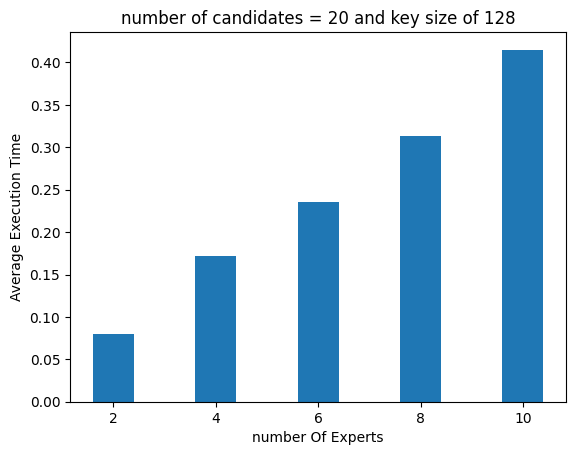

[[0.23987099100122578, 0.24313143600011244, 0.4312147249984264, 0.602792525998666, 0.8912956790009048], [0.13481088100161287, 0.28218531200036523, 0.5132483690031222, 0.6151132269988011, 0.9804801039972517], [0.16504166799859377, 0.2818173440027749, 0.4465585359976103, 0.6626494200027082, 0.9194033169987961], [0.13674210300086997, 0.2677577620015654, 0.4417534650019661, 0.6964974309994432, 0.9514080449989706], [0.1205551600032777, 0.22721798500060686, 0.43504766000114614, 0.6598332780013152, 0.8173853740008781], [0.13837374500144506, 0.25772296200011624, 0.43682631499905256, 0.7173266089994286, 0.8660393139980442], [0.1313249690028897, 0.32369175299754716, 0.4994127559984918, 0.698537528001907, 0.9951276620013232], [0.13089485300224624, 0.2571218030025193, 0.4470450560002064, 0.7250750830025936, 0.85819430400079], [0.14640838200284634, 0.29401151899946854, 0.5058408749973751, 0.7007913200031908, 0.8191890430025524], [0.13763867300076527, 0.2587914149989956, 0.3926922540013038, 0.674146

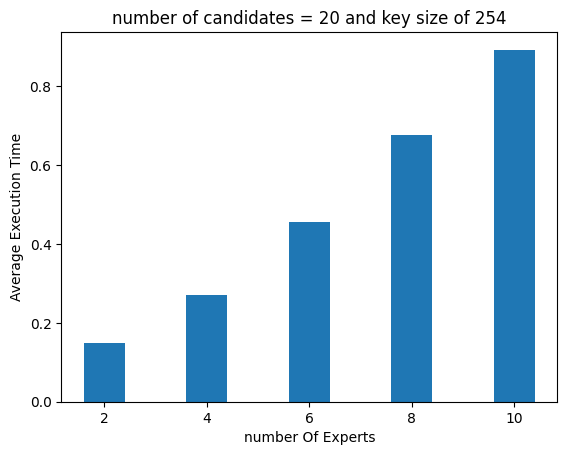

[[0.5914904009987367, 0.9670711220023804, 1.6827088800018828, 2.5922476409978117, 3.743458210003155], [0.5013329989997146, 0.8790413479982817, 1.6179585690006206, 2.6447347459979937, 4.0037425119990075], [0.4372973829995317, 0.9553221220012347, 1.6749336899993068, 2.585442753999814, 3.9851497170020593], [0.49280483899929095, 0.9877968639993924, 1.6876681499998085, 2.6700683390008635, 3.8907855750003364], [0.4936905869981274, 0.9959152859992173, 1.6451345889981894, 2.670732416998362, 3.8294979050006077], [0.5550145750021329, 0.938654461002443, 1.5646762670003227, 2.7066883520019474, 3.8528807059992687], [0.484680613000819, 0.8562900709985115, 1.6287428370014823, 2.5229508459997305, 3.914628395999898], [0.4150073149976379, 1.033792796999478, 1.6840236469979573, 2.5860515120002674, 3.8687129489990184], [0.4630196149992116, 0.9008524199998647, 1.6647101800008386, 2.604425457000616, 3.7925540739997814], [0.4358756639994681, 0.9395286569997552, 1.7209903369985113, 2.641339904999768, 3.926886

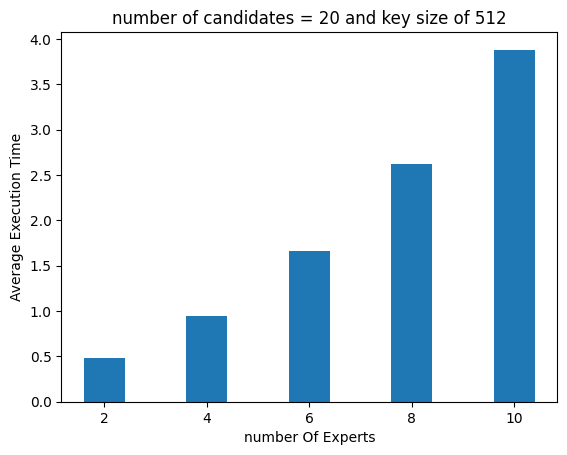

In [455]:
keys = [128,254,512]
for i in range(0,3):
    simulationHavingExpertsvariableCandidatesConst([2,4,6,8,10],20,"experts",keys[i])

[[0.16931656499946257, 0.26378806800130405, 0.38586949599994114, 0.25942570800179965, 0.25921731400012504], [0.1536170530016534, 0.19724677199701546, 0.19645940600094036, 0.23289569299959112, 0.2249891999999818], [0.17809445499733556, 0.2350540320003347, 0.18800327500139247, 0.24381078599981265, 0.3184855029976461], [0.12192710300223553, 0.27683559700017213, 0.21934104200045113, 0.2583812039993063, 0.2850674769979378], [0.14405835500292596, 0.17562134599938872, 0.2567768740009342, 0.27026341799864895, 0.3066755319996446], [0.22581579699908616, 0.11974034199738526, 0.24948576200040407, 0.2876872309971077, 0.2384553629999573], [0.16386473500097054, 0.22544533100153785, 0.24961999399965862, 0.2574647960027505, 0.28459030100202654], [0.12639798700183746, 0.22639315400010673, 0.2330945329995302, 0.1933760110005096, 0.30182198799957405], [0.0911695629984024, 0.17410772500079474, 0.2178897420017165, 0.2172446590011532, 0.3309438409996801], [0.1474259599999641, 0.15588431599826436, 0.283834737

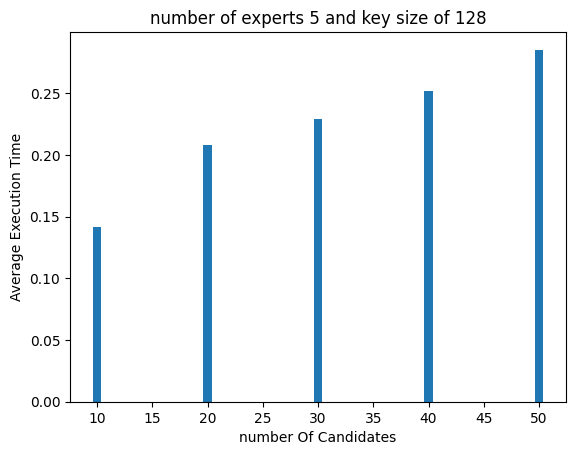

[[0.24455887699878076, 0.43412445400099386, 0.47588225200161105, 0.6260426330009068, 0.7496416440008034], [0.2603922500020417, 0.3715177349986334, 0.39839934200063, 0.5818904950028809, 0.7020782239997061], [0.19110403399827192, 0.34746481699767173, 0.5155177020023984, 0.6203286009986186, 0.6220999489996757], [0.3292617250008334, 0.35091462499985937, 0.5456608360000246, 0.5927013360014826, 0.7777743570004532], [0.22709629400196718, 0.36517145600009826, 0.4973657800001092, 0.6343275060025917, 0.6882627300001332], [0.2321639799993136, 0.3716844640002819, 0.52759355300077, 0.5262878920002549, 0.6675658539970755], [0.29204130800280836, 0.34595139100201777, 0.4236226209977758, 0.6089790020014334, 0.7003523239982314], [0.2684524969990889, 0.4511961570024141, 0.46247932099868194, 0.6571949199969822, 0.6697285030022613], [0.23319333199833636, 0.4200816360025783, 0.4151248019988998, 0.59618776500065, 0.7379789959995833], [0.21426438499838696, 0.34182658400095534, 0.5116081929991196, 0.6144190169

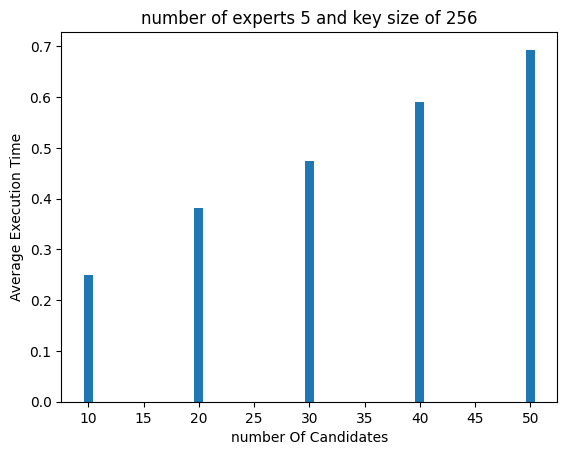

[[0.7367146060023515, 1.234968007000134, 1.7466599850013154, 2.2172198740008753, 2.643986995997693], [0.683267196000088, 1.1622490849986207, 1.7609649160003755, 2.331325226001354, 2.65521633300159], [0.7100416540015431, 1.3106319319995237, 1.7138914639981522, 2.235009167001408, 2.7836785560029966], [0.6471639980009058, 1.1643068630000926, 1.6608514039980946, 2.226539015999151, 2.853462209997815], [0.6711760079997475, 1.132599668999319, 1.7886838920021546, 2.2752210500002548, 2.8643782309991366], [0.7250003420012945, 1.2044942899992748, 1.787026613001217, 2.388812618999509, 2.931591650001792], [0.7573288889980176, 1.3126023750010063, 1.7379023110006528, 2.333454430998245, 2.7913376560027245], [0.7469357200025115, 1.2704420350019063, 1.6715593919980165, 2.3896302670000296, 2.901059042997076], [0.6841171119995124, 1.3168713249979191, 1.7404163860010158, 2.2704784529996687, 2.7387484020000556], [0.769060411999817, 1.3035845630001859, 1.8193176589993527, 2.345842637001624, 2.778528475999337

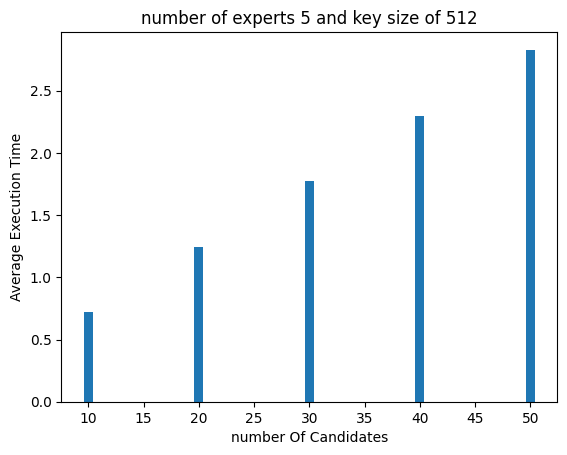

In [459]:
keys = [128,256,512]
for i in range(0,3):
    simulationHavingExpertsConstCandidatesVariable(5,[10,20,30,40,50],"candidates",keys[i])
